# MLP Baseline train and evaluation
Uses modified code from https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial7/GNN_overview.ipynb#scrollTo=QMN2C1_gPU3J.

Loops over each data object in a given root folder and runs a Multilayer Perceptron (MLP) model over it. Places results in a list of results, alongside a separate list for model predictions. Finally, generates ROC curves for each fold and calculates the mean AUC and standard deviation of AUC for the specified model.

Note: this notebook is designed to load in data from a directory that has processed data objects created from a notebook in 'src/Data Object Generation/'. You need data objects calculated from that folder before running this notebook.

In [1]:
# Sets seed for Pytorch Lightning, sklearn, numpy, etc.
SEED = 1

# defines learning rate and weight decay for Adam optimizer
l_rate = 5e-4
w_decay = 5e-2

# defines max epochs for training
max_epochs = 10000

# defines # of hidden layers, # of nodes per hidden layer, & dropout rate
n_layers = 2
n_nodes = 16
drop_rate = 0.1

# root path to access calculated data objects
root_path = '../../data/lab-ovr-m5,0.85-short-dir'

In [2]:
## Standard libraries
import os
import os.path as osp
import numpy as np 
import pandas as pd
from dtw import *

## Imports for plotting
import matplotlib.pyplot as plt

## PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
from torchmetrics import F1Score

# Imports for f1, AUC/ROC
from sklearn.metrics import auc, roc_auc_score, RocCurveDisplay

# Torchvision
import torchvision
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

from torch_geometric.data import Dataset, download_url, Data
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE

# torch geometric
try: 
    import torch_geometric
except ModuleNotFoundError:
    # Installing torch geometric packages with specific CUDA+PyTorch version. 
    # See https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html for details 
    TORCH = torch.__version__.split('+')[0]
    CUDA = 'cu' + torch.version.cuda.replace('.','')

    !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-geometric 
    import torch_geometric
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../../saved_models/"

# Setting the seed for pl, numpy, sklearn
pl.seed_everything(SEED)
np.random.seed(SEED)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



Global seed set to 1


cuda:0


In [3]:
# converts weights returned by model into classifications.
# NOTE: returned tensor is cpu-side! If using GPU, you
#       need to switch it back over.
# Returns: LongTensor with classifications
def to_predictions(prob):
    pred = prob.cpu().detach().numpy().flatten()
    for i in range(len(pred)):
        if pred[i] < 0:
            pred[i] = 0
        else:
            pred[i] = 1
    return torch.LongTensor(pred)

## Graph Neural Network

In [4]:
gnn_layer_by_name = {
    "GCN": geom_nn.GCNConv,
    "GAT": geom_nn.GATConv,
    "GraphConv": geom_nn.GraphConv
}

In [5]:
# class from tutorial. defines Graph Neural Network with a 
# specified type of layer.
class GNNModel(nn.Module):
    
    def __init__(self, c_in, c_hidden, c_out, num_layers=2, layer_name="GCN", dp_rate=0.1, heads=6, **kwargs):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of the output features. Usually number of classes in classification
            num_layers - Number of "hidden" graph layers
            layer_name - String of the graph layer to use
            dp_rate - Dropout rate to apply throughout the network
            kwargs - Additional arguments for the graph layer (e.g. number of heads for GAT)
        """
        super().__init__()
        gnn_layer = gnn_layer_by_name[layer_name]
    
        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers-1):
            in_channels_idx = in_channels * heads if l_idx > 0 else in_channels
            layers += [
                gnn_layer(in_channels=in_channels_idx, 
                          out_channels=out_channels,
                          heads=heads,
                          **kwargs),
                nn.ReLU(inplace=True),
                nn.Dropout(dp_rate)
            ]
            in_channels = c_hidden * heads
        layers += [gnn_layer(in_channels=in_channels, 
                             out_channels=c_out,
                             heads=heads,
                             **kwargs)]
        self.layers = nn.ModuleList(layers)
    
    def forward(self, x, edge_index):
        """
        Inputs:
            x - Input features per node
            edge_index - List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
        """
        for l in self.layers:
            # For graph layers, we need to add the "edge_index" tensor as additional input
            # All PyTorch Geometric graph layer inherit the class "MessagePassing", hence
            # we can simply check the class type.
            if isinstance(l, geom_nn.MessagePassing):
                x = l(x, edge_index)
            else:
                x = l(x)
        return x

In [6]:
# class from tutorial. defomes baseline MLP model.
class MLPModel(nn.Module):
    
    def __init__(self, c_in, c_hidden, c_out, num_layers=2, dp_rate=0.1):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of the output features. Usually number of classes in classification
            num_layers - Number of hidden layers
            dp_rate - Dropout rate to apply throughout the network
        """
        super().__init__()
        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers-1):
            layers += [
                nn.Linear(in_channels, out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout(dp_rate)
            ]
            in_channels = c_hidden
        layers += [nn.Linear(in_channels, c_out)]
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x, *args, **kwargs):
        """
        Inputs:
            x - Input features per node
        """
        return self.layers(x)

In [7]:
# class from tutorial. combines both classes above
# to streamline pytorch lightning train/eval.
class NodeLevelGNN(pl.LightningModule):
    
    def __init__(self, model_name, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()
        self.num_epochs = 0
        if model_name == "MLP":
            self.model = MLPModel(**model_kwargs)
        else:
            self.model = GNNModel(**model_kwargs)
        self.loss_module = nn.BCEWithLogitsLoss(reduction='mean') # nn.CrossEntropyLoss() 

    def forward(self, data, mode="train"):
        x, edge_index = data.x, data.edge_index
        x = self.model(x, edge_index)
        
        # Only calculate the loss on the nodes corresponding to the mask
        if mode == "train":
            mask = data.train_mask
        elif mode == "val":
            mask = data.val_mask
        elif mode == "test":
            mask = data.test_mask
        else:
            assert False, f"Unknown forward mode: {mode}"
        # print(x[mask])
        loss = self.loss_module(x[mask], data.y[mask].unsqueeze(1).float())
        if (self.num_epochs % 1000 == 0):
            print('epoch', self.num_epochs // 2, ': loss =', loss.cpu().numpy())
        self.num_epochs += 1
        pred = to_predictions(x[mask])
        # move predictions to gpu if y is also in gpu
        if data.y.get_device() != -1:
            pred = pred.to(device=device)
        acc = (pred == data.y[mask]).sum().float() / mask.sum() # (x[mask].argmax(dim=-1) == data.y[mask]).sum().float() / mask.sum()
        return loss, acc

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),
                             lr=l_rate, 
                             weight_decay=w_decay)
        return optimizer

    def training_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="train")
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="val")
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="test")
        self.log('test_acc', acc)

In [8]:
# function from tutorial. trains and evaluates model.
def train_node_classifier(model_name, dataset, **model_kwargs):
    pl.seed_everything(SEED)
    node_data_loader = geom_data.DataLoader(dataset, batch_size=1)
    
    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "NodeLevel" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         gpus=1 if str(device).startswith("cuda") else 0,
                         max_epochs=max_epochs,
                         progress_bar_refresh_rate=0) # 0 because epoch size is 1
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    model = NodeLevelGNN(model_name=model_name, c_in=dataset.num_node_features, c_out=dataset.num_classes, **model_kwargs)
    trainer.fit(model, node_data_loader, node_data_loader)
    model = NodeLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
    
    # Test best model on the test set
    test_result = trainer.test(model, node_data_loader, verbose=False)
    batch = next(iter(node_data_loader))
    batch = batch.to(model.device)
    _, train_acc = model.forward(batch, mode="train")
    _, val_acc = model.forward(batch, mode="val")
    result = {"train": train_acc,
              "val": val_acc,
              "test": test_result[0]['test_acc']}
    return model, result

Finally, we can train our models. First, let's train the simple MLP:

In [9]:
# function from tutorial. small function for printing the test scores
def print_results(result_dict):
    if "train" in result_dict:
        print(f"Train accuracy: {(100.0*result_dict['train']):4.2f}%")
    if "val" in result_dict:
        print(f"Val accuracy:   {(100.0*result_dict['val']):4.2f}%")
    print(f"Test accuracy:  {(100.0*result_dict['test']):4.2f}%")

In [10]:
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

# creates graph of ROC curve based on k-fold list of ground truths
# and 1-dimensional array of probability. lightly modified sample code from 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
def ROC_kfoldCV(y_tests, prob_lists, fig_title="Receiver operating characteristic"):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(7, 5.5), dpi=80)

    for i in range(len(y_tests)):
        viz = RocCurveDisplay.from_predictions(
            y_tests[i],
            prob_lists[i],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )
    print('mean AUC:', mean_auc)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title=fig_title,
    )
    ax.legend(loc="lower right")
    plt.show()

In [16]:
# creates lightly modified sample code from 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
def get_mean_curve(y_tests, prob_lists, fig_title="Receiver operating characteristic", save_folder=None):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(7, 5.5), dpi=80)

    for i in range(len(y_tests)):
        viz = RocCurveDisplay.from_predictions(
            y_tests[i],
            prob_lists[i],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            # ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    print(type(mean_auc))
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )
    print('mean AUC:', mean_auc)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#     ax.fill_between(
#         mean_fpr,
#         tprs_lower,
#         tprs_upper,
#         color="grey",
#         alpha=0.2,
#         label=r"$\pm$ 1 std. dev.",
#     )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title=fig_title,
    )
    ax.legend(loc="lower right")
    plt.show()
    
    # save mean_auc, std_auc, mean_tpr, & mean_fpr into file
    if save_folder != None:
        np.savetxt(save_folder + '/mean_fpr.csv', mean_fpr, delimiter=',')
        np.savetxt(save_folder + '/mean_tpr.csv', mean_tpr, delimiter=',')
        np.savetxt(save_folder + '/mean_auc.csv', np.array([mean_auc]), delimiter=',')
        np.savetxt(save_folder + '/std_auc.csv', np.array([std_auc]), delimiter=',')

### Define dataset for storing tenfold CV Data objects

In [11]:
# Dataset class definition that loads the 10 data objects created 
# by tenfold_cross_val on a given root directory. 
# Cannot process / generate its own data: you must first run 
# tenfold_cross_val on the given root directory in the given notebook 
# in 'src/Data Object Generation' with the raw data files x_pd.csv, 
# y_pd.csv, and imputed_lab.csv. 
class TenfoldDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.num_classes = 1
        

    @property
    def raw_file_names(self):
        return ['x_pd.csv', 'y_pd.csv', 'imputed_lab.csv']

    @property
    def processed_file_names(self):
        return ['data_0.pt', 'data_1.pt', 'data_2.pt', 'data_3.pt', 'data_4.pt', 
                'data_5.pt', 'data_6.pt', 'data_7.pt', 'data_8.pt', 'data_9.pt']

    def download(self):
        pass

    def process(self):
        raise Exception('Please use tenfold_cross_val to generate the .pt files for this dataset.')
    
    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
        return data

In [12]:
# loop through all data objects in tenfold CV & train/test/calculate f1 score on the data

tenfold_data = TenfoldDataset(root=root_path)
# f1 = F1Score(num_classes = 2) <- torch version
results_list = []
y_test_list = []
prob_list = []

for i in range(10):
    tenfold_i = tenfold_data[i:i + 1]
    print('\nstarting round', i + 1, 'of 10:')
    print(tenfold_i[0])
    node_mlp_model, node_mlp_result = train_node_classifier(model_name="MLP",
                                                        dataset=tenfold_i, 
                                                        c_hidden=n_nodes, 
                                                        num_layers=n_layers,
                                                        dp_rate=drop_rate)
    
    print_results(node_mlp_result)
    # calculate f1-micro/macro & auc score, show classifications    
    probs = node_mlp_model.model(tenfold_i[0].x, tenfold_i[0].edge_index)
    pred = to_predictions(probs[tenfold_i[0].test_mask]).numpy()
    ground_truths = tenfold_i[0].y[tenfold_i[0].test_mask].numpy()
    results_list += [[node_mlp_model, node_mlp_result]]
    
    # convert result into a 1d array of probs to calculate auc
    probs_arr = probs[tenfold_i[0].test_mask].detach().numpy()
    
    y_test_list += [ground_truths]
    prob_list += [probs_arr]
    
    print('auc score:', roc_auc_score(ground_truths, probs_arr))
    
    print('predictions: ', pred)
    print('ground-truth:', ground_truths)

    
print('----------------------------\ndone!')

Global seed set to 1
C:\Users\caryx\anaconda3\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



starting round 1 of 10:
Data(x=[1260, 124], edge_index=[2, 2311], y=[1260], train_mask=[1260], test_mask=[1260], val_mask=[1260], num_classes=2)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params
--------------------------------------------------
0 | model       | MLPModel          | 2.0 K 
1 | loss_module | BCEWithLogitsLoss | 0     
--------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


epoch 0 : loss = 0.70657873


C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\utilities\data.py:72: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1260. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:1933: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


epoch 500 : loss = 0.57417345
epoch 1000 : loss = 0.5746269
epoch 1500 : loss = 0.57546294
epoch 2000 : loss = 0.5746582
epoch 2500 : loss = 0.57493407
epoch 3000 : loss = 0.5724451
epoch 3500 : loss = 0.57445383
epoch 4000 : loss = 0.5741063
epoch 4500 : loss = 0.5742177
epoch 5000 : loss = 0.57206
epoch 5500 : loss = 0.5734681
epoch 6000 : loss = 0.5708089
epoch 6500 : loss = 0.57420254
epoch 7000 : loss = 0.57355225
epoch 7500 : loss = 0.57524866
epoch 8000 : loss = 0.57453585
epoch 8500 : loss = 0.5730646
epoch 9000 : loss = 0.57447654
epoch 9500 : loss = 0.5726429


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 1
C:\Users\caryx\anaconda3\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument

epoch 10000 : loss = 0.5737563
epoch 0 : loss = 0.59507847
Train accuracy: 75.40%
Val accuracy:   78.41%
Test accuracy:  72.73%
auc score: 0.7389397406559879
predictions:  [0 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 1
 0 0 0 0 1 0 0 0 1 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 1 1 0 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 1
 0 1 0 1 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1]
ground-truth: [0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1
 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 1 1
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0]

starting round 2 of 10:
Data(x=[1252, 124], edge_index=[2, 2506], y=[1252], train_mask=[1252], te

C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\utilities\data.py:72: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1252. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this ma

epoch 500 : loss = 0.6101385
epoch 1000 : loss = 0.6110281
epoch 1500 : loss = 0.6074649
epoch 2000 : loss = 0.60840964
epoch 2500 : loss = 0.60945475
epoch 3000 : loss = 0.60856736
epoch 3500 : loss = 0.60972404
epoch 4000 : loss = 0.60928845
epoch 4500 : loss = 0.6102567
epoch 5000 : loss = 0.6087158
epoch 5500 : loss = 0.6094859
epoch 6000 : loss = 0.60896266
epoch 6500 : loss = 0.6104118
epoch 7000 : loss = 0.60896695
epoch 7500 : loss = 0.6085813
epoch 8000 : loss = 0.61110324
epoch 8500 : loss = 0.60834086
epoch 9000 : loss = 0.60964835
epoch 9500 : loss = 0.60785925


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 1
C:\Users\caryx\anaconda3\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument

epoch 10000 : loss = 0.60993
epoch 0 : loss = 0.6213533
Train accuracy: 75.91%
Val accuracy:   67.05%
Test accuracy:  69.32%
auc score: 0.6727474972191324
predictions:  [0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0
 0 0 1 0 1 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1
 0 1 0 0 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 1 0 0 0 0 1 0 1 0]
ground-truth: [0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]

starting round 3 of 10:
Data(x=[1244, 124], edge_index=[2, 2359], y=[1244], train_mask=[1244], test_

C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\utilities\data.py:72: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1244. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this ma

epoch 500 : loss = 0.5701113
epoch 1000 : loss = 0.56920373
epoch 1500 : loss = 0.57001966
epoch 2000 : loss = 0.5693232
epoch 2500 : loss = 0.5699215
epoch 3000 : loss = 0.56923884
epoch 3500 : loss = 0.5700813
epoch 4000 : loss = 0.57013416
epoch 4500 : loss = 0.57176644
epoch 5000 : loss = 0.57080126
epoch 5500 : loss = 0.56890726
epoch 6000 : loss = 0.5699503
epoch 6500 : loss = 0.5700448
epoch 7000 : loss = 0.570156
epoch 7500 : loss = 0.5724357
epoch 8000 : loss = 0.5717378
epoch 8500 : loss = 0.5688373
epoch 9000 : loss = 0.56951296
epoch 9500 : loss = 0.5700784


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 1
C:\Users\caryx\anaconda3\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument

epoch 10000 : loss = 0.5683318
epoch 0 : loss = 0.64403707
Train accuracy: 70.51%
Val accuracy:   76.14%
Test accuracy:  65.34%
auc score: 0.6988855116514692
predictions:  [0 0 0 0 1 1 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1 0
 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1 0 1 0 0 0 1 0
 1 0 1 0 0 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0
 1 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1 0
 0 1 1 1 1 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0]
ground-truth: [0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 1 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0
 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0
 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0]

starting round 4 of 10:
Data(x=[1258, 124], edge_index=[2, 2737], y=[1258], train_mask=[1258], te

C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\utilities\data.py:72: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1258. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this ma

epoch 500 : loss = 0.62901753
epoch 1000 : loss = 0.634486
epoch 1500 : loss = 0.6349519
epoch 2000 : loss = 0.6350795
epoch 2500 : loss = 0.63663745
epoch 3000 : loss = 0.63609976
epoch 3500 : loss = 0.6353766
epoch 4000 : loss = 0.6341698
epoch 4500 : loss = 0.6361985
epoch 5000 : loss = 0.63344055
epoch 5500 : loss = 0.6343082
epoch 6000 : loss = 0.6344576
epoch 6500 : loss = 0.6351286
epoch 7000 : loss = 0.6346617
epoch 7500 : loss = 0.635583
epoch 8000 : loss = 0.6350462
epoch 8500 : loss = 0.6354645
epoch 9000 : loss = 0.6342712
epoch 9500 : loss = 0.63447


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 1
C:\Users\caryx\anaconda3\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument

epoch 10000 : loss = 0.63427675
epoch 0 : loss = 0.5796711
Train accuracy: 78.87%
Val accuracy:   69.32%
Test accuracy:  71.59%
auc score: 0.7245236122618062
predictions:  [0 0 1 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 1 0 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0 1
 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 0 0 1 0 0 0 1 0
 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0
 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
ground-truth: [0 0 1 0 0 1 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1
 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]

starting round 5 of 10:
Data(x=[1234, 124], edge_index=[2, 2218], y=[1234], train_mask=[1234], te

C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\utilities\data.py:72: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1234. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this ma

epoch 500 : loss = 0.638005
epoch 1000 : loss = 0.64075625
epoch 1500 : loss = 0.6399376
epoch 2000 : loss = 0.6390488
epoch 2500 : loss = 0.64349914
epoch 3000 : loss = 0.63977873
epoch 3500 : loss = 0.6421242
epoch 4000 : loss = 0.64132535
epoch 4500 : loss = 0.6413235
epoch 5000 : loss = 0.63990194
epoch 5500 : loss = 0.6411025
epoch 6000 : loss = 0.64022285
epoch 6500 : loss = 0.64309734
epoch 7000 : loss = 0.64189786
epoch 7500 : loss = 0.64054483
epoch 8000 : loss = 0.6408733
epoch 8500 : loss = 0.6413961
epoch 9000 : loss = 0.6388774
epoch 9500 : loss = 0.64034843


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 1
C:\Users\caryx\anaconda3\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument

epoch 10000 : loss = 0.6389243
epoch 0 : loss = 0.5957666
Train accuracy: 75.05%
Val accuracy:   59.09%
Test accuracy:  76.14%
auc score: 0.6911764705882353
predictions:  [0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1
 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 0
 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 1
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0]
ground-truth: [1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0
 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0]

starting round 6 of 10:
Data(x=[1242, 124], edge_index=[2, 2245], y=[1242], train_mask=[1242], tes

C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\utilities\data.py:72: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1242. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this ma

epoch 500 : loss = 0.59163713
epoch 1000 : loss = 0.5945255
epoch 1500 : loss = 0.59210265
epoch 2000 : loss = 0.5911453
epoch 2500 : loss = 0.5951072
epoch 3000 : loss = 0.5927481
epoch 3500 : loss = 0.59452987
epoch 4000 : loss = 0.59295183
epoch 4500 : loss = 0.59413266
epoch 5000 : loss = 0.5909013
epoch 5500 : loss = 0.59336776
epoch 6000 : loss = 0.5908691
epoch 6500 : loss = 0.5942069
epoch 7000 : loss = 0.5933938
epoch 7500 : loss = 0.5918815
epoch 8000 : loss = 0.5963161
epoch 8500 : loss = 0.59317684
epoch 9000 : loss = 0.59255457
epoch 9500 : loss = 0.5939575


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 1
C:\Users\caryx\anaconda3\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument

epoch 10000 : loss = 0.59354156
epoch 0 : loss = 0.6106277
Train accuracy: 78.22%
Val accuracy:   70.45%
Test accuracy:  68.18%
auc score: 0.6242009132420091
predictions:  [0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 1 0
 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 1 1 1 1 0 0 0
 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1
 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0]
ground-truth: [0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0
 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]

starting round 7 of 10:
Data(x=[1240, 124], edge_index=[2, 2237], y=[1240], train_mask=[1240], te

C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\utilities\data.py:72: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1240. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this ma

epoch 500 : loss = 0.6253806
epoch 1000 : loss = 0.62525326
epoch 1500 : loss = 0.62718314
epoch 2000 : loss = 0.6251669
epoch 2500 : loss = 0.6288014
epoch 3000 : loss = 0.6267139
epoch 3500 : loss = 0.6313693
epoch 4000 : loss = 0.62348855
epoch 4500 : loss = 0.630158
epoch 5000 : loss = 0.6258383
epoch 5500 : loss = 0.6275146
epoch 6000 : loss = 0.6265077
epoch 6500 : loss = 0.6305898
epoch 7000 : loss = 0.6267353
epoch 7500 : loss = 0.62560993
epoch 8000 : loss = 0.6280437
epoch 8500 : loss = 0.6282481
epoch 9000 : loss = 0.6262712
epoch 9500 : loss = 0.62725174


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 1
C:\Users\caryx\anaconda3\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument

epoch 10000 : loss = 0.62828875
epoch 0 : loss = 0.601883
Train accuracy: 78.07%
Val accuracy:   62.50%
Test accuracy:  68.18%
auc score: 0.6856410256410257
predictions:  [0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0
 0 1 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 0 0 1 0 0
 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0 1 1 1 1
 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0
 1 1 0 1 1 0 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
ground-truth: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0
 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 1]

starting round 8 of 10:
Data(x=[1264, 124], edge_index=[2, 2595], y=[1264], train_mask=[1264], tes

C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\utilities\data.py:72: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1264. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this ma

epoch 500 : loss = 0.56182545
epoch 1000 : loss = 0.55693054
epoch 1500 : loss = 0.55773634
epoch 2000 : loss = 0.556937
epoch 2500 : loss = 0.5586167
epoch 3000 : loss = 0.55933267
epoch 3500 : loss = 0.5568539
epoch 4000 : loss = 0.55747825
epoch 4500 : loss = 0.5586564
epoch 5000 : loss = 0.55676776
epoch 5500 : loss = 0.55722487
epoch 6000 : loss = 0.55661696
epoch 6500 : loss = 0.55853826
epoch 7000 : loss = 0.55790573
epoch 7500 : loss = 0.5578191
epoch 8000 : loss = 0.55828357
epoch 8500 : loss = 0.55733794
epoch 9000 : loss = 0.5577374
epoch 9500 : loss = 0.55715364


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 1
C:\Users\caryx\anaconda3\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument

epoch 10000 : loss = 0.55668557
epoch 0 : loss = 0.64158326
Train accuracy: 72.30%
Val accuracy:   77.27%
Test accuracy:  66.48%
auc score: 0.7019249465292632
predictions:  [0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0 1 1 1 1 0 0 0 0 0 0 1 0 0 1 0 0 1 1
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 1 0 1 1 0 0 0 1 0 0 1 0 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 1 1 1 1 0 1 0 1 0 0 1 0 1 1 0 0 0 1 1 0
 0 1 1 1 1 1 1 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0
 1 0 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1 1 0]
ground-truth: [0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1
 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0
 1 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1
 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 1 1]

starting round 9 of 10:
Data(x=[1272, 124], edge_index=[2, 2738], y=[1272], train_mask=[1272], t

C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\utilities\data.py:72: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1272. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this ma

epoch 500 : loss = 0.609944
epoch 1000 : loss = 0.6077219
epoch 1500 : loss = 0.6081983
epoch 2000 : loss = 0.6085664
epoch 2500 : loss = 0.6103475
epoch 3000 : loss = 0.6096676
epoch 3500 : loss = 0.61053884
epoch 4000 : loss = 0.61000556
epoch 4500 : loss = 0.6112709
epoch 5000 : loss = 0.60908955
epoch 5500 : loss = 0.61061096
epoch 6000 : loss = 0.60808444
epoch 6500 : loss = 0.6112097
epoch 7000 : loss = 0.6107555
epoch 7500 : loss = 0.6074794
epoch 8000 : loss = 0.6111903
epoch 8500 : loss = 0.61115944
epoch 9000 : loss = 0.60902864
epoch 9500 : loss = 0.61044985


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 1
C:\Users\caryx\anaconda3\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument

epoch 10000 : loss = 0.60921973
epoch 0 : loss = 0.64475787
Train accuracy: 72.62%
Val accuracy:   68.18%
Test accuracy:  66.48%
auc score: 0.7172538392050588
predictions:  [0 0 0 1 1 1 1 0 1 0 1 0 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 1 1 1 0 0 0 1 1 0 1
 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 0 0 1
 0 1 1 1 0 0 0 0 1 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0
 1 0 1 1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0
 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1]
ground-truth: [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0
 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 1 1 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0
 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0
 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]

starting round 10 of 10:
Data(x=[1266, 124], edge_index=[2, 2770], y=[1266], train_mask=[1266], 

C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\utilities\data.py:72: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1266. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this ma

epoch 500 : loss = 0.5735241
epoch 1000 : loss = 0.5731153
epoch 1500 : loss = 0.57353944
epoch 2000 : loss = 0.57309663
epoch 2500 : loss = 0.5732421
epoch 3000 : loss = 0.57458425
epoch 3500 : loss = 0.57328254
epoch 4000 : loss = 0.57477605
epoch 4500 : loss = 0.57382154
epoch 5000 : loss = 0.5729995
epoch 5500 : loss = 0.57500225
epoch 6000 : loss = 0.57323146
epoch 6500 : loss = 0.574364
epoch 7000 : loss = 0.57244086
epoch 7500 : loss = 0.57306284
epoch 8000 : loss = 0.57721806
epoch 8500 : loss = 0.5754331
epoch 9000 : loss = 0.57406026
epoch 9500 : loss = 0.57410157


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


epoch 10000 : loss = 0.5752331
epoch 0 : loss = 0.59409404
Train accuracy: 75.85%
Val accuracy:   72.73%
Test accuracy:  72.16%
auc score: 0.7189054726368159
predictions:  [0 1 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0
 0 0 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0
 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0
 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 0 1]
ground-truth: [0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0
 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0
 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0]
----------------------------
done!


C:\Users\caryx\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


mean AUC: 0.6973799250173867


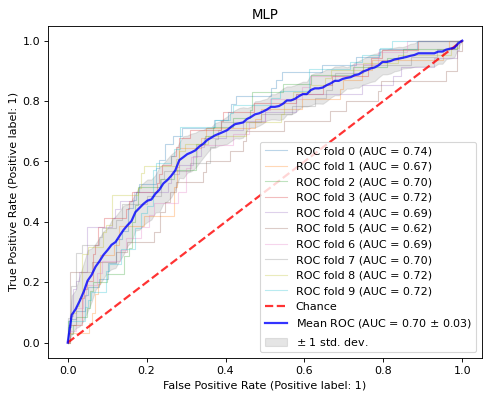

In [14]:
ROC_kfoldCV(y_test_list, prob_list, 'MLP')

<class 'numpy.float64'>
mean AUC: 0.6973799250173867


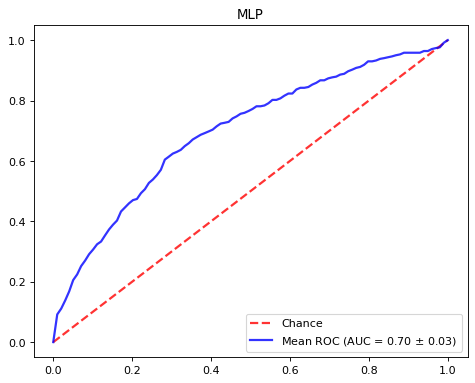

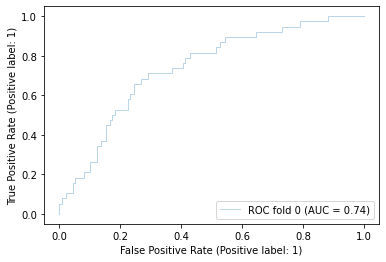

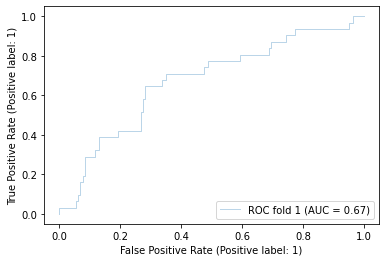

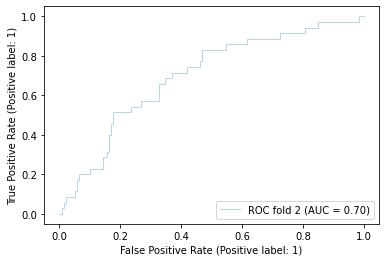

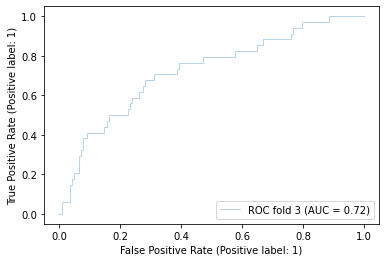

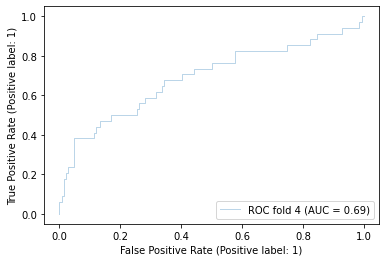

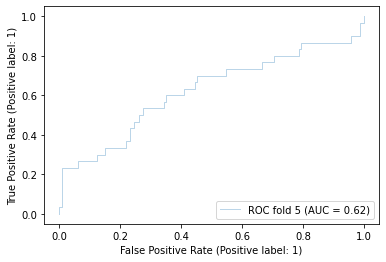

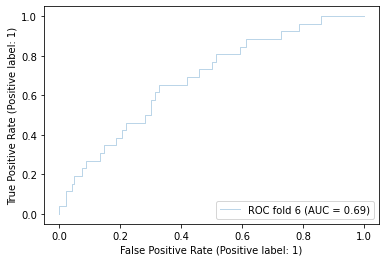

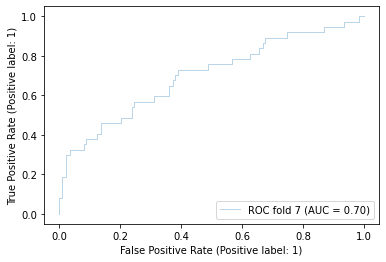

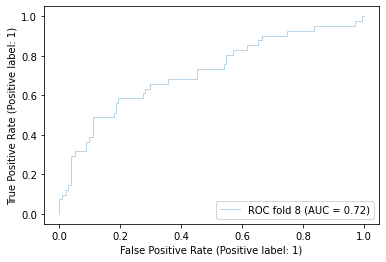

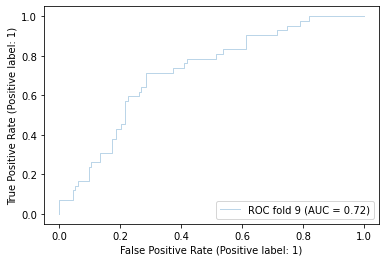

In [17]:
get_mean_curve(y_test_list, prob_list, 'MLP', './ROC Curves/MLP')